В этой работе я провел иерархическую кластеризацию 474 образцов по экспрессии по-разному отобранных генов и проанализировал получившийся результат. В процессе работы были выявлены схожие с оригинальными статьями патерны для каждого из кластеров, но так же имели место и некоторые отличия. 

In [ ]:
pip install lifelines

     |████████████████████████████████| 348kB 7.8MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp37-none-any.whl size=4035 sha256=5958e74c3d49c9c99f53bbb3ce4e7d9f8e16b9d69de4abebe0581757277326db
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-gamma


ToDo:
1. Реализовать класс EXPRESSIONS \\
Параметры - табличка. \\
Методы - кластеризация, z-scoring, распределение экспрессии гена, gene clusterisation list.

2. Класс CLUSTERISATION. \\
Параметры - количество кластеров, табличка, гены кластеризации.
Методы - график кластеров, heatmap.

3. Класс PATIENTS. \\
Параметры - табличка. \\
Методы - KMP, вулкан для пациента

In [3]:
def GeneFinder(genes):
    genes_ID = []
    for gene in genes:
        if mg.query(gene, fields='entrezgene')['hits']:
            try:
                genes_ID.append(mg.query(gene, fields='entrezgene')['hits'][0]['entrezgene'])
            except (KeyError):
                warnings.warn('Gene {} not found'.format(gene))
                pass
        else:
            warnings.warn('Gene {} not found'.format(gene))
    return (genes_ID)

In [5]:
mg = mygene.MyGeneInfo()

In [6]:
class EXPRESSIONS:
    
    def __init__(self, path_rnaseq, path_patient, path_sample):
        self.rna_seq = pd.read_csv(path_rnaseq, sep = "\t")
        self.data_patient = pd.read_csv(path_patient, sep = "\t")
        self.path_sample = pd.read_csv(path_sample, sep = "\t")

    def gene_distribution(self, gene_names):
        rna_seq = a.rna_seq.copy() # создаём копию, чтобы избежать лишних проблем
        rna_seq.set_index("Entrez_Gene_Id", inplace= True)
        corrected_names = GeneFinder(gene_names)
        plt.figure(figsize=(12, 7))
        for i, j in zip(corrected_names, range(0, len(corrected_names))):
                #print(i, j, rna_seq.loc[i][2::])
                plt.subplot(2, 2, j+1)
                sns.distplot(rna_seq.loc[int(i)][2::], axlabel = rna_seq.loc[int(i)][0])
    
    def clustering(self):
        '''
        Calculating the clusterisation of data based on rna sequencing.
        
        warning: cophenetic correlation of clusterisation
        
        returns object of CLUSTERING class
        '''
        
        rna_seq = self.rna_seq.set_index("Hugo_Symbol").copy() #теперь чтобы обратиться к строке нужно использовать имя гена, а не индекс
        #print(rna_seq)
        rna_mad = rna_seq.drop(['Entrez_Gene_Id'], axis = 1).T.mad()
        rna_seq.insert(1, "mad", np.array(rna_mad))
        
        rna_seq_clast1 = rna_seq.copy() #выделим датасет, в котором проведем класетризацию
        rna_seq_clast1 = rna_seq_clast1.sort_values(["mad"], ascending=False) #отберем наиболее альтернативно экспресируемые гены до z-скорирования,
        # тк оно выравнивает все среднеквадратичные отклонения, а метрика mad ей аналогична
        rna_seq_clast1 = rna_seq_clast1[:1500]
        rna_seq_clast1 = rna_seq_clast1.drop("Entrez_Gene_Id", 1)
        rna_seq_clast1 = rna_seq_clast1.drop("mad", 1)
        rna_seq_clast1 = (rna_seq_clast1.T - rna_seq_clast1.T.median())/rna_seq_clast1.T.std()
        rna_seq_clast1 = rna_seq_clast1.dropna(1) #выбросим гены, вернувшие None
        
        
        
        rna_seq_clast_arr1 = np.array(rna_seq_clast1)
        Z1 = sci.linkage(rna_seq_clast_arr1, 'ward')
        
        c, coph_dists = sci.cophenet(Z1, pdist(rna_seq_clast_arr1))
        warnings.warn(f'Cophenetic correlation is equal to {c}')
        
        return CLUSTERING(Z1, rna_seq_clast1)

In [160]:
class CLUSTERING:
    def __init__(self, Z, expressions):
        """
        class for cluterized data
        n - number of clusters
        Z - scoring output
        expressions - pd.dataframe with IDs and expressions
        """
        self.Z = Z
        self.expressions = expressions
        
    def dendogram(self, y = False):
        """
        Build dendogram for hierachial clustering
        param:
        y - cutline
        """
        plt.figure(figsize=(25, 10)) #строим двоичное дерево для нормированных данных
        plt.title('Кластеризация нормированных данных')
        plt.xlabel('sample index')
        plt.ylabel('distance')
        sci.dendrogram(
          self.Z,
          leaf_rotation=9.,  
          leaf_font_size=2., 
        )
        if y:
            plt.axhline(y=y, c='r')
        plt.show()
  
    def expression_clustering(self, n):
        """
        returns expression table with clusters
        param:
        n - number of slusters the data will be clusterized
        """
        clasters = sci.fcluster(self.Z, n, criterion='maxclust')
        expression_clusterized = self.expressions.copy()
        expression_clusterized.insert(0, "Cluster", np.array(clasters))
        return (expression_clusterized)
    
    def sample_clustering(self, n, samples):
        """
        returns sample table with clusters
        param:
        n - number of clusters
        samples - pd.dataframe with samples without service rows
        """
        expression_clusterized = self.expression_clustering(n)
        sample_proc = samples.copy()
        indexes = list(set(sample_proc.index).intersection(set(expression_clusterized.index)))
        sample_proc.insert(0, "Cluster", -1)
        for ind in indexes:
            sample_proc["Cluster"][ind] = expression_clusterized["Cluster"][ind]
        broken = sample_proc[sample_proc["Cluster"] == -1].index
        if len(broken):
            warnings.warn('{} samples were droped'.format(len(broken)))
        sample_proc.drop(broken, inplace = True)
        return (sample_proc)
    
    def patient_clustering(self, n, samples, patients):
        """
        returns patient table with clusters
        param:
        n - number of clusters
        samples - pd.dataframe with samples without service rows
        patients - pd.dataframe with patients without service rows
        """
        sample_proc = self.sample_clustering(n, samples)
        patients_proc = patients.copy()
        patients_proc.insert(0, "Cluster", -1)
        for ind in sample_proc.index:
            patients_proc['Cluster'][sample_proc['#Patient Identifier'][ind]] = sample_proc['Cluster'][ind]
        broken = patients_proc[patients_proc["Cluster"] == -1].index
        if len(broken):
            warnings.warn('{} patient forms were droped'.format(len(broken)))
        patients_proc.drop(broken, inplace = True)
        return patients_proc
    
    def Caplan_Meier(self, n, samples, patients, ci_show = False):
        """
        returns Caplan_Meier diagram with track for each cluster
        param:
        n - number of clusters
        samples - pd.dataframe with samples without service rows
        patients - pd.dataframe with patients without service rows
        """
        patients_proc = self.patient_clustering(n, samples, patients)
        patients_proc.drop(patients_proc[patients_proc['Overall Survival (Months)'] == '[Not Available]'].index, inplace = True)
        events = []
        durations = []
        km = []
        plt.figure(figsize=(25, 10))
        for i in range (n):
            events = list(patients_proc['Overall Survival Status'][patients_proc['Cluster'] == i+1].apply(lambda x: int(x[0])))
            durations = list(patients_proc['Overall Survival (Months)'][patients_proc['Cluster'] == i+1].apply(float))
            kk = KaplanMeierFitter()
            km.append(kk.fit(np.array(durations)/12, events, label='claster {}'.format(i+1)))
        for i in range (n):
            km[i].plot(ci_show=ci_show)
        plt.title('Survival analysis, {} clusters'.format(n), size = 15)
        plt.xlabel('Time, years', size = 15)
        plt.ylabel('Survival rate', size = 15)
        #return (km)
    
    def Heat_Map_Overexpression(self, n, *args):
        """
        returns heatmap with overexpressed genes
        param - number of clusters
        *args - threshold of overexpression for each cluster
        """
        exp = self.expression_clustering(n)
        gene_lists = []
        for i in range (1, n+1):
            exp_i = exp[exp['Cluster'] == i].copy()
            for j in list(exp_i.columns)[1:]:
                if exp_i[j].mean() > exp[j].mean() + thresholds[i-1]:
                    gene_lists.append(j)
        
        plt.figure(figsize=(20, 10))
        plt.title('Upregulation heatmap', size = 15)
        ax = sns.heatmap(exp.sort_values(["Cluster"], ascending=True)[gene_lists], cmap="ocean")
        
    def Heat_Map_Downexpression(self, n, *args):
        """
        returns heatmap with overexpressed genes
        param - number of clusters
        *args - threshold of overexpression for each cluster
        """
        exp = self.expression_clustering(n)
        gene_lists = []
        for i in range (1, n+1):
            exp_i = exp[exp['Cluster'] == i].copy()
            for j in list(exp_i.columns)[1:]:
                if exp_i[j].mean() < exp[j].mean() - thresholds[i-1]:
                    gene_lists.append(j)
        plt.figure(figsize=(20, 10))
        plt.title('Downregulation heatmap', size = 15)
        ax = sns.heatmap(exp.sort_values(["Cluster"], ascending=True)[gene_lists], cmap="ocean")

In [ ]:
def PATIENTS:
    def __init__(self, Patients, )

In [59]:
def overexpression(claster_data, rate = 0.1): # claster_data - DataFrame с кластеризованными данными, rate - степень отличия от средней экспрессии по всем образцам
    overexpressed_genes = []
    for i in claster_data.columns:
        if claster_data[i].mean() > rna_seq_clast1[i].mean() + rate:
            overexpressed_genes.append(i)
    return (overexpressed_genes)

NameError: name 'clast1_duration' is not defined

In [202]:
from scipy.signal import deconvolve
b.expressions

Hugo_Symbol,D12S53E,ADAM6,GAPDH,CD74,FN1,VIM,OI4,BMS1P20,APOD,LOC115571,...,C21orf112,COX7C,LOC115390,LTBR,LOC643556,WLS,NARS,ENDOD1,PLEKHH1,RENBP
TCGA-3N-A9WB-06,0.511567,-0.059269,2.013903,-0.378939,-0.453835,1.206173,-0.008704,-0.055143,-0.110200,1.608306,...,0.257587,2.667063,-0.625413,0.637517,0.820340,0.347086,-0.102687,-0.178541,0.062865,2.065948
TCGA-3N-A9WC-06,-0.507717,0.680521,-0.025051,1.834639,-0.109611,-0.905992,-0.025823,0.359784,0.065984,0.222486,...,-1.343517,0.936955,-0.459478,-0.085278,0.947903,0.762234,0.365710,0.581173,-0.256473,0.007796
TCGA-3N-A9WD-06,-0.272235,0.780726,0.126553,0.403391,0.871195,-0.499393,-0.091279,0.302421,-0.083828,0.208057,...,-1.083714,1.512612,-0.010326,0.482369,0.790356,0.362180,0.017306,-0.235344,-0.016583,-0.523235
TCGA-BF-A1PU-01,1.031365,-0.067110,0.460343,-0.350882,1.670685,0.383492,0.182547,-0.057338,0.644116,1.664216,...,0.408034,0.218149,2.272932,0.006495,-0.854452,-0.969362,1.114624,0.087226,1.861169,0.790393
TCGA-BF-A1PV-01,-0.142724,-0.022456,-0.621047,-0.349568,4.252442,1.954405,-0.000107,-0.025393,-0.120916,0.271847,...,0.198674,-0.825097,3.700035,0.836708,-0.189271,-0.040202,1.328230,0.079953,-0.075936,-0.266523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-YG-AA3O-06,0.308249,-0.035687,-0.294907,-0.191849,0.258820,-0.130111,0.118251,0.034470,0.123442,0.037913,...,-1.181887,0.534037,-0.096031,-0.063793,0.840709,-0.129543,0.257673,-0.164741,0.570491,-0.163421
TCGA-YG-AA3P-06,-0.506745,-0.062243,2.342948,-0.325078,-0.509056,1.539480,-0.171836,-0.037081,-0.153120,-0.878756,...,2.845305,1.225536,-0.497377,-0.343341,0.859970,-0.626740,0.813403,-0.656116,0.634609,0.964280
TCGA-Z2-A8RT-06,0.130203,0.224683,-0.337353,0.252721,0.003096,1.175533,-0.028868,0.198601,0.140327,-0.830188,...,-0.119689,-0.490970,-0.593793,-0.419992,0.595346,-0.397927,-0.587728,0.865208,-0.001796,1.635672
TCGA-Z2-AA3S-06,-0.287207,-0.047228,-0.737584,-0.229420,-0.546788,-1.045987,-0.176611,-0.022566,-0.083852,-0.995158,...,0.972592,0.324473,-0.664463,-0.117312,0.731133,1.540653,0.970656,-0.292105,0.402281,0.135227


In [124]:
k = b.expression_clustering(3)
k[k['Cluster'] == 3]['D12S53E']

Hugo_Symbol,Cluster,D12S53E,ADAM6,GAPDH,CD74,FN1,VIM,OI4,BMS1P20,APOD,...,C21orf112,COX7C,LOC115390,LTBR,LOC643556,WLS,NARS,ENDOD1,PLEKHH1,RENBP
TCGA-3N-A9WB-06,3,0.511567,-0.059269,2.013903,-0.378939,-0.453835,1.206173,-0.008704,-0.055143,-0.110200,...,0.257587,2.667063,-0.625413,0.637517,0.820340,0.347086,-0.102687,-0.178541,0.062865,2.065948
TCGA-3N-A9WC-06,3,-0.507717,0.680521,-0.025051,1.834639,-0.109611,-0.905992,-0.025823,0.359784,0.065984,...,-1.343517,0.936955,-0.459478,-0.085278,0.947903,0.762234,0.365710,0.581173,-0.256473,0.007796
TCGA-3N-A9WD-06,3,-0.272235,0.780726,0.126553,0.403391,0.871195,-0.499393,-0.091279,0.302421,-0.083828,...,-1.083714,1.512612,-0.010326,0.482369,0.790356,0.362180,0.017306,-0.235344,-0.016583,-0.523235
TCGA-BF-A1PV-01,3,-0.142724,-0.022456,-0.621047,-0.349568,4.252442,1.954405,-0.000107,-0.025393,-0.120916,...,0.198674,-0.825097,3.700035,0.836708,-0.189271,-0.040202,1.328230,0.079953,-0.075936,-0.266523
TCGA-BF-A1PX-01,3,-0.189694,0.448745,0.396742,0.914795,0.025841,-0.671658,0.748281,0.320836,0.217970,...,-0.174575,-0.171726,1.435410,0.843453,-0.531213,0.361722,-0.496204,1.411831,0.090030,0.216053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-YD-A9TB-06,3,-0.366193,-0.004515,-0.805676,-0.041262,-0.311926,-0.549540,1.263895,-0.020536,0.188094,...,2.804724,-0.402500,-0.125646,-0.977348,-0.212696,0.100255,-0.959079,0.212652,0.154950,0.573563
TCGA-YG-AA3O-06,3,0.308249,-0.035687,-0.294907,-0.191849,0.258820,-0.130111,0.118251,0.034470,0.123442,...,-1.181887,0.534037,-0.096031,-0.063793,0.840709,-0.129543,0.257673,-0.164741,0.570491,-0.163421
TCGA-YG-AA3P-06,3,-0.506745,-0.062243,2.342948,-0.325078,-0.509056,1.539480,-0.171836,-0.037081,-0.153120,...,2.845305,1.225536,-0.497377,-0.343341,0.859970,-0.626740,0.813403,-0.656116,0.634609,0.964280
TCGA-Z2-A8RT-06,3,0.130203,0.224683,-0.337353,0.252721,0.003096,1.175533,-0.028868,0.198601,0.140327,...,-0.119689,-0.490970,-0.593793,-0.419992,0.595346,-0.397927,-0.587728,0.865208,-0.001796,1.635672


In [136]:
a = EXPRESSIONS("data_RNA_Seq_v2_expression_median.txt", "data_bcr_clinical_data_patient.txt", "data_bcr_clinical_data_sample.txt")

In [161]:
b = a.clustering()

C:\Users\luppo\anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Cophenetic correlation is equal to 0.5528767865474054


In [149]:
b.expression_clustering(3).sort_values(["Cluster"], ascending=True)

Hugo_Symbol,Cluster,D12S53E,ADAM6,GAPDH,CD74,FN1,VIM,OI4,BMS1P20,APOD,...,C21orf112,COX7C,LOC115390,LTBR,LOC643556,WLS,NARS,ENDOD1,PLEKHH1,RENBP
TCGA-Z2-AA3V-06,1,3.789182,0.334369,2.754287,2.980032,-0.435649,0.153861,0.049906,0.164900,0.025454,...,-1.209353,0.190279,1.001037,2.047071,-0.711634,-0.868820,-1.157725,-0.763586,-0.142823,6.023322
TCGA-FS-A1ZQ-06,1,0.839826,0.107179,2.174414,-0.031123,0.640404,-0.741794,-0.067288,0.056256,0.313610,...,0.554521,-0.354734,1.188975,3.538301,-0.587834,0.653162,-0.197741,-0.229930,1.078519,0.051469
TCGA-FS-A1ZY-06,1,-0.057278,-0.067685,0.438739,-0.371353,-0.268379,0.325221,-0.036905,-0.058757,1.042758,...,0.734499,-0.556973,-0.113864,0.569615,-0.524289,2.923096,-0.552181,-0.453911,2.633923,0.071421
TCGA-DA-A95Y-06,1,2.408741,0.005985,1.846446,-0.300272,-0.410106,0.414006,-0.141684,-0.025082,1.178180,...,0.413962,0.855080,-0.540664,0.165825,-0.070412,-0.537624,0.344494,1.994323,-0.080874,0.938442
TCGA-DA-A95V-06,1,2.856638,6.328747,4.024378,0.572734,-0.449117,0.846622,-0.119236,2.862840,-0.129298,...,-0.145698,0.663075,0.125153,0.780490,-0.151247,-0.194801,0.629130,-0.712807,1.321308,0.053448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-EB-A57M-01,3,0.286521,1.220902,-0.384696,0.309687,1.161678,1.515460,1.503244,0.295599,0.084383,...,-0.265811,-0.504789,4.349951,0.024284,-0.644323,0.090427,0.049683,-0.476747,-0.411397,0.492215
TCGA-EB-A553-01,3,0.632809,0.134818,1.118061,0.032012,-0.430026,1.302182,0.287119,0.166198,-0.134445,...,-1.430069,1.395497,0.739461,1.055321,3.272761,-1.047028,-0.781542,-0.640394,3.700358,1.534104
TCGA-EB-A551-01,3,-0.507818,0.897401,-0.685706,0.389417,-0.006600,-0.189651,0.046005,0.406054,-0.021989,...,-0.080066,-0.001304,-0.572588,-1.153794,1.045029,-1.051165,0.921719,-0.165091,1.676705,0.175856
TCGA-EB-A51B-01,3,-0.010684,-0.068351,0.973311,2.222581,1.723561,1.235400,-0.139515,-0.057719,-0.126373,...,-0.602971,-1.070801,-0.174996,2.574292,0.996774,0.815857,-0.144084,0.423014,-0.553012,0.209101


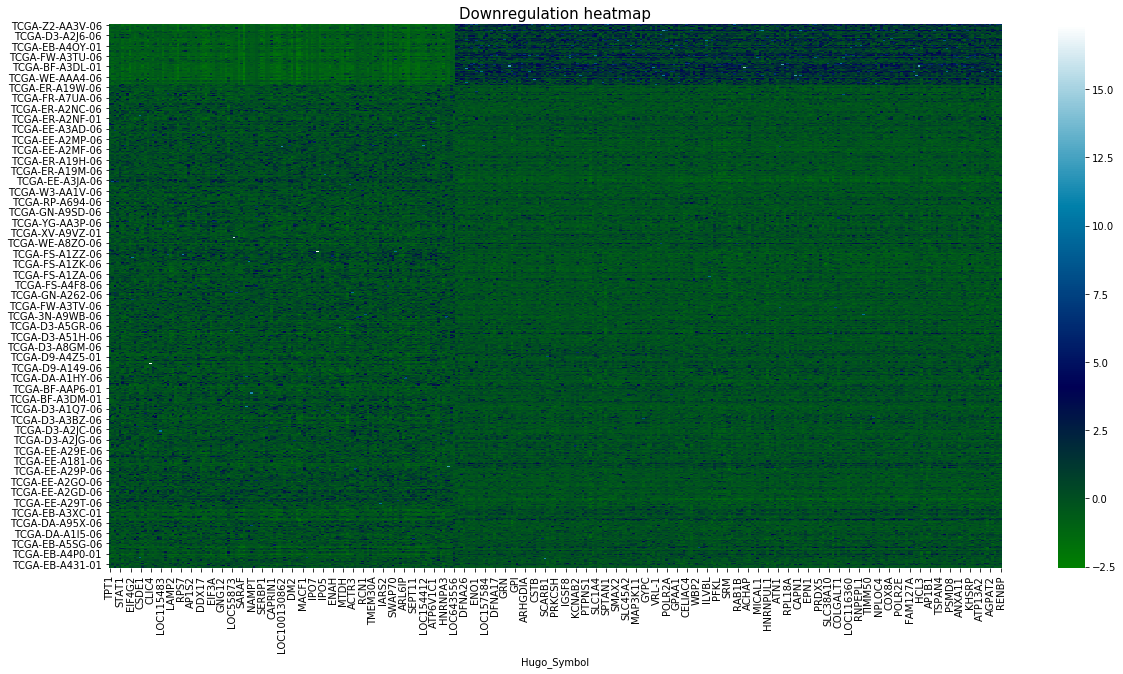

In [162]:
thresholds = (0.6, 0.15)
b.Heat_Map_Downexpression(2, thresholds)

C:\Users\luppo\anaconda3\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\luppo\anaconda3\lib\site-packages\ipykernel_launcher.py:57: UserWarning: 8 samples were droped
C:\Users\luppo\anaconda3\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\luppo\anaconda3\lib\site-packages\ipykernel_launcher.py:76: UserWarning: 1 patient forms were droped


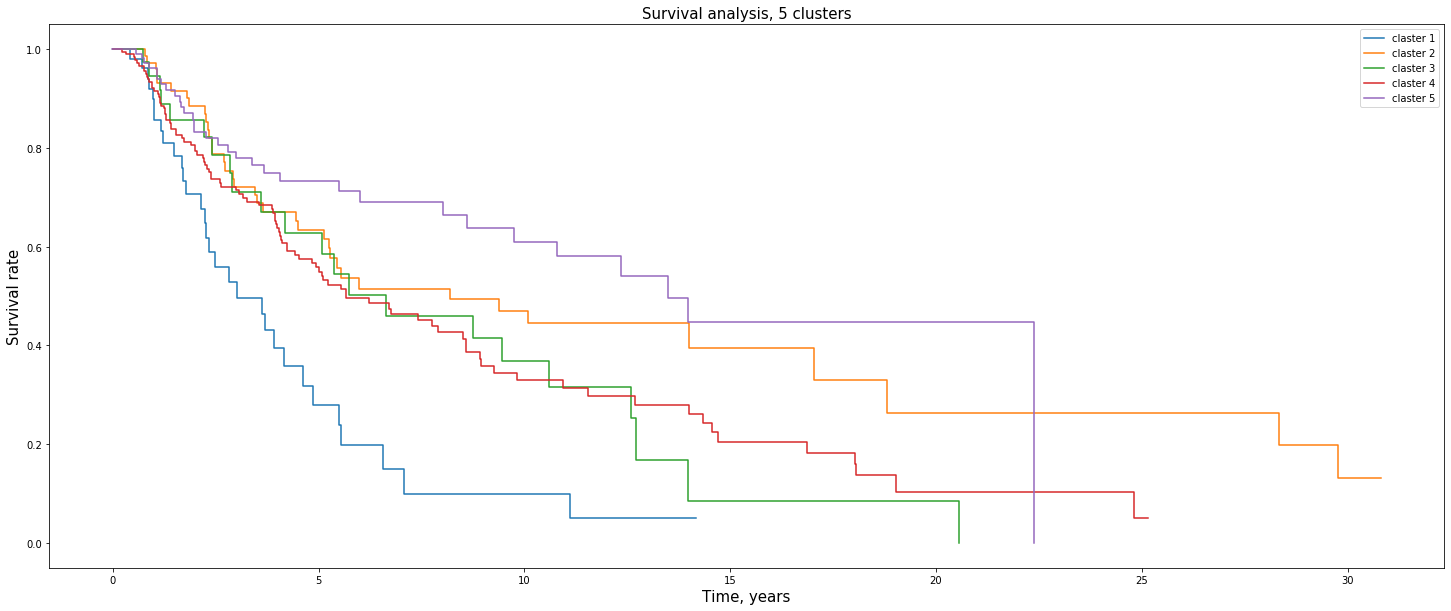

In [164]:
b.Caplan_Meier(5, data_sample_proc, data_patient_proc)

C:\Users\luppo\anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\luppo\anaconda3\lib\site-packages\ipykernel_launcher.py:45: UserWarning: 8 samples were droped
C:\Users\luppo\anaconda3\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\luppo\anaconda3\lib\site-packages\ipykernel_launcher.py:57: UserWarning: 1 patient forms were droped


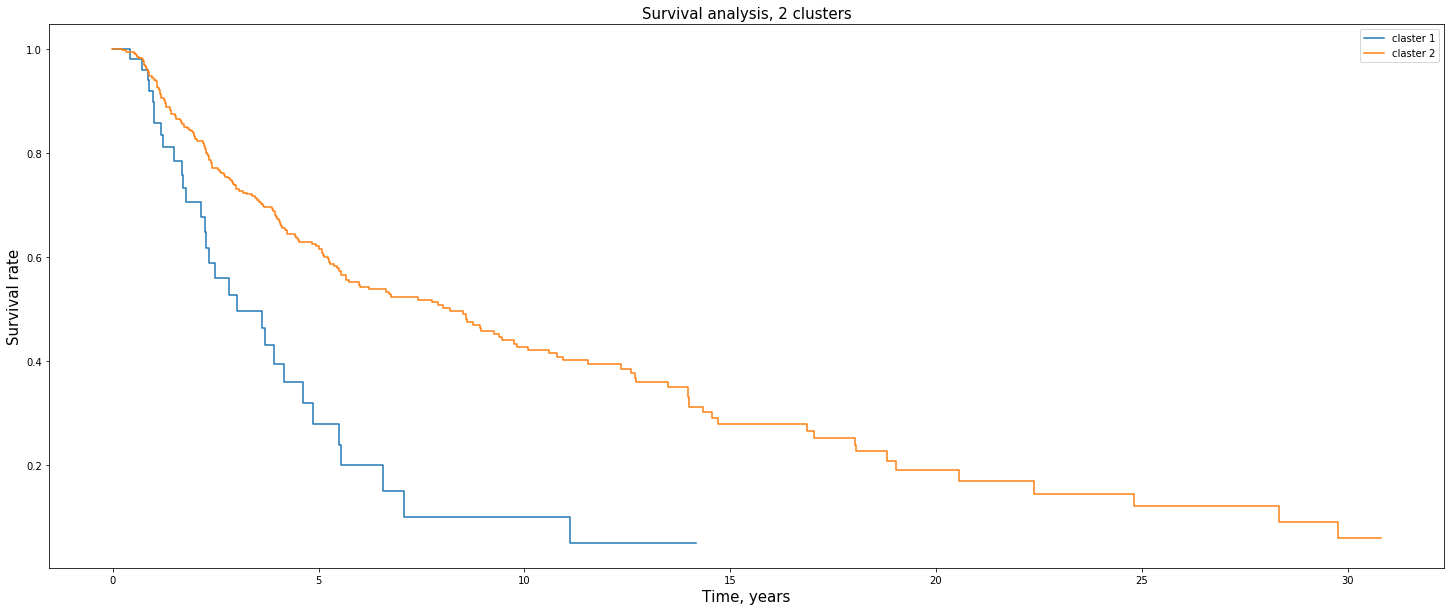

In [117]:
km = b.Caplan_Meier(2, data_sample_proc, data_patient_proc)

In [151]:
plt.figure(figsize=(25, 10))
kmf1 = KaplanMeierFitter() 
kmf1.fit(np.array(clast1_duration)/12, clast1_event ,label='claster1')
kmf1.plot(ci_show=False)
kmf2 = KaplanMeierFitter() 
kmf2.fit(np.array(clast2_duration)/12, clast2_event ,label='claster2')
kmf2.plot(ci_show=False)
kmf3 = KaplanMeierFitter() 
kmf3.fit(np.array(clast3_duration)/12, clast3_event ,label='claster3')
kmf3.plot(ci_show=False)
plt.title('Анализ выживаемости, 3 кластера', size = 15)
plt.xlabel('Время, годы', size = 15)
plt.ylabel('Выживаемость', size = 15)

ValueError: could not convert string to float: '[Not Available]'

In [183]:
from scipy.stats import ttest_ind
ttest_ind([1, 1], [2, 1000])

Ttest_indResult(statistic=-1.002004008016032, pvalue=0.4218791603097063)

In [201]:
from scipy.stats import mannwhitneyu
mannwhitneyu([1], [1, 2, 3, 4, 5, 1, 1.0000001, 1.000001, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1.00000001, 1.01, 1.01])


MannwhitneyuResult(statistic=6.0, pvalue=0.22683170386669593)

In [77]:
sample_proc["Cluster"]['TCGA-BF-A1PU-01'] = 1

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


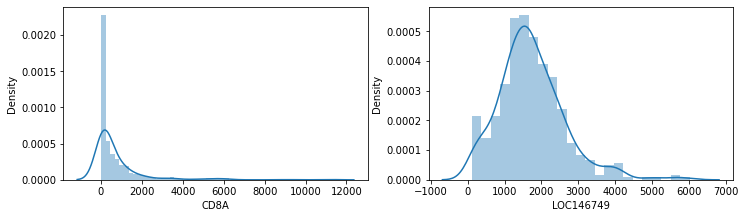

In [83]:
a.gene_distribution(["CD8A", "TP53"])

In [ ]:
class CLASTERING:
  def __init__(self, Z):
    self.Z = Z


In [197]:
patients_data

NameError: name 'patients_data' is not defined

In [11]:
pip install mygene

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd #работа с таблицами
import matplotlib.pyplot as plt #графики
import seaborn as sns #статистика
import numpy as np #векторы
import scipy.cluster.hierarchy as sci #кластеризация
from lifelines import KaplanMeierFitter #анализ выживаемости
from scipy.spatial.distance import pdist #анализ качества кластеризации
import mygene #для сопоставления генов из разных статей
import warnings #для предупреждений

In [ ]:
def GeneFinder(genes):
    genes_ID = []
    for gene in genes:
        if mg.query(gene, fields='entrezgene')['hits']:
            try:
                genes_ID.append(mg.query(gene, fields='entrezgene')['hits'][0]['entrezgene'])
            except (KeyError):
                warnings.warn('Gene {} not found'.format(gene))
                pass
    return ()

In [12]:
rna_seq = pd.read_csv("data_RNA_Seq_v2_expression_median.txt", sep = "\t")
data_patient = pd.read_csv("data_bcr_clinical_data_patient.txt", sep = "\t")
data_sample = pd.read_csv("data_bcr_clinical_data_sample.txt", sep = "\t")

In [199]:
data_sample_proc.loc['TCGA-BF-A1PV-01':'TCGA-HR-A2OG-01']

,#Patient Identifier,Is FFPE,Oct embedded,Sample Type,Sample type id,Vial number,Cancer Type,Cancer Type Detailed,Somatic Status
Sample Identifier,,,,,,,,,
TCGA-BF-A1PV-01,TCGA-BF-A1PV,NO,TRUE,Primary,1,A,Melanoma,Cutaneous Melanoma,Matched
TCGA-BF-A1PX-01,TCGA-BF-A1PX,NO,TRUE,Primary,1,A,Melanoma,Cutaneous Melanoma,Matched
TCGA-BF-A1PZ-01,TCGA-BF-A1PZ,NO,TRUE,Primary,1,A,Melanoma,Cutaneous Melanoma,Matched
TCGA-BF-A1Q0-01,TCGA-BF-A1Q0,NO,TRUE,Primary,1,A,Melanoma,Cutaneous Melanoma,Matched
TCGA-D3-A1Q1-06,TCGA-D3-A1Q1,NO,TRUE,Metastasis,6,A,[Not Available],[Not Available],Matched
...,...,...,...,...,...,...,...,...,...
TCGA-XV-AAZY-01,TCGA-XV-AAZY,NO,TRUE,Primary,1,A,Melanoma,Cutaneous Melanoma,Matched
TCGA-XV-AB01-06,TCGA-XV-AB01,NO,TRUE,Metastasis,6,A,[Not Available],[Not Available],Matched
TCGA-YD-A9TB-06,TCGA-YD-A9TB,NO,FALSE,Metastasis,6,A,[Not Available],[Not Available],Matched


В первой статье анализировались 1500 генов с самым большим разбросом значения экспрессии. Выберем их из списка всех анализируемых генов:

In [ ]:
rna_seq.set_index("Hugo_Symbol", inplace= True) #теперь чтобы обратиться к строке нужно использовать имя гена, а не индекс

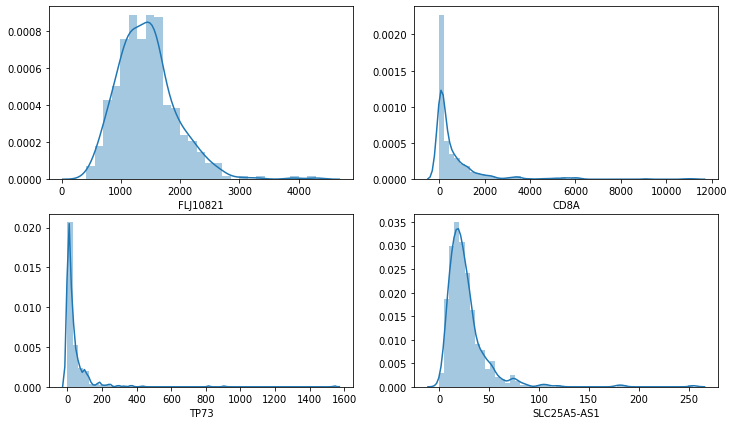

In [ ]:
plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1)
sns.distplot(rna_seq.loc["FLJ10821"][2::])
plt.subplot(2, 2, 2)
sns.distplot(rna_seq.loc["CD8A"][2::])
plt.subplot(2, 2, 3)
sns.distplot(rna_seq.loc["TP73"][2::])
plt.subplot(2, 2, 4)
sns.distplot(rna_seq.loc["SLC25A5-AS1"][2::])

Как мы можем видеть, распределения многих генов далеки от нормального, по этому вместо среднеквадратичного отклонения для отбора наиболее диф. экспрессированных генов используем более простую, упомянутую в статье метрику абсолютного отклонения.  

Получим выборку для кластеризации на 1500 наиболее диф. экспрессированных генах. 

In [ ]:
rna_mad = rna_seq.T.mad()
rna_seq.insert(1, "mad", np.array(rna_mad))

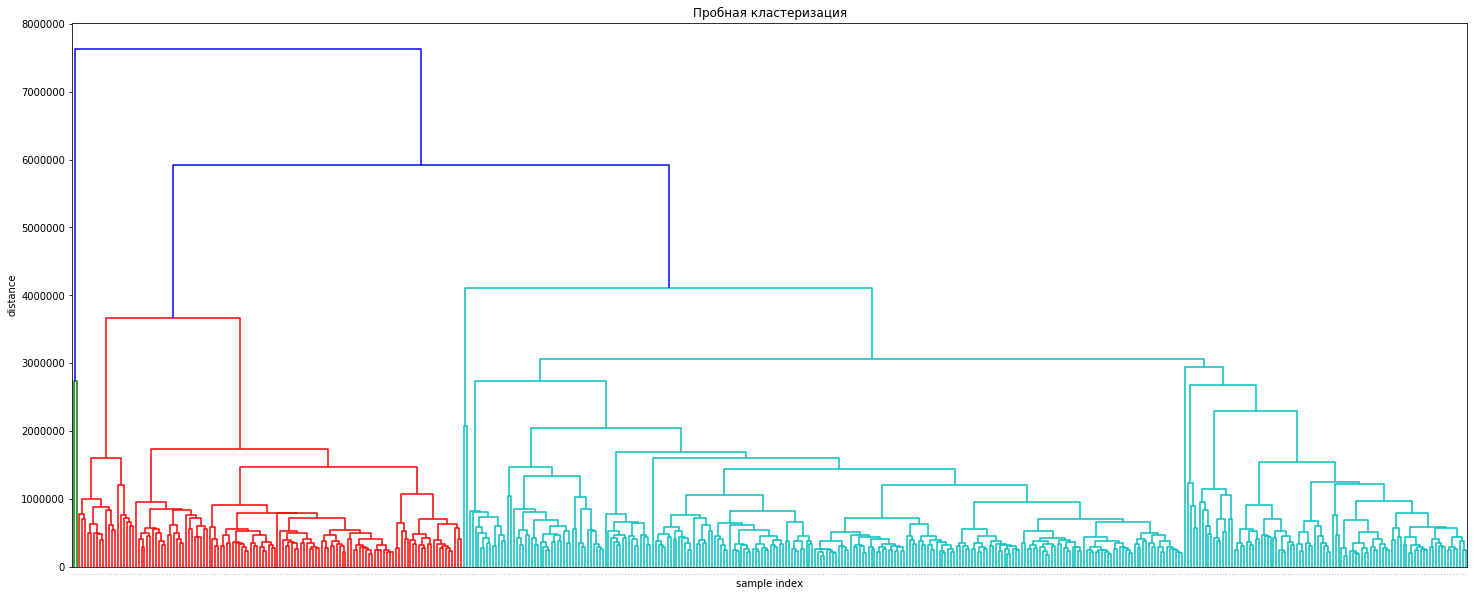

In [ ]:
rna_seq_clast = rna_seq.copy()
rna_seq_clast = rna_seq_clast.sort_values(["mad"], ascending=False)
rna_seq_clast = rna_seq_clast[:1500]
rna_seq_clast = rna_seq_clast.T

rna_seq_clast_arr = np.array(rna_seq_clast[2::])
Z = sci.linkage(rna_seq_clast_arr, 'ward') #кластеризацию осуществляет эта функция

plt.figure(figsize=(25, 10)) #построим двоичное дерево, получившееся после нашей клстеризации
plt.title('Пробная кластеризация')
plt.xlabel('sample index')
plt.ylabel('distance')
sci.dendrogram(
    Z,
    leaf_rotation=9.,
    leaf_font_size=1., 
)
plt.show()

In [ ]:
c, coph_dists = sci.cophenet(Z, pdist(rna_seq_clast_arr))
c

0.3490048222179949

Двоичное дерево выглядит странно. В нем наблюдаются выбросы и расстояния получились очень большими, Cophenetic correlation мала, z-скорируем (представим их в виде отклонения от среднего, выраженного в стандартных отклонениях)  данные и повторим процедуру.

In [ ]:
rna_seq_clast1 = rna_seq.copy() #выделим датасет, в котором проведем класетризацию
rna_seq_clast1 = rna_seq_clast1.sort_values(["mad"], ascending=False) #отберем наиболее альтернативно экспресируемые гены до z-скорирования,
# тк оно выравнивает все среднеквадратичные отклонения, а метрика mad ей аналогична
rna_seq_clast1 = rna_seq_clast1[:1500]
rna_seq_clast1 = rna_seq_clast1.drop("Entrez_Gene_Id", 1)
rna_seq_clast1 = rna_seq_clast1.drop("mad", 1)
rna_seq_clast1 = (rna_seq_clast1.T - rna_seq_clast1.T.median())/rna_seq_clast1.T.std()
rna_seq_clast1 = rna_seq_clast1.dropna(1) #выбросим гены, вернувшие None


In [ ]:
rna_seq_clast_arr1 = np.array(rna_seq_clast1)

Z1 = sci.linkage(rna_seq_clast_arr1, 'ward')

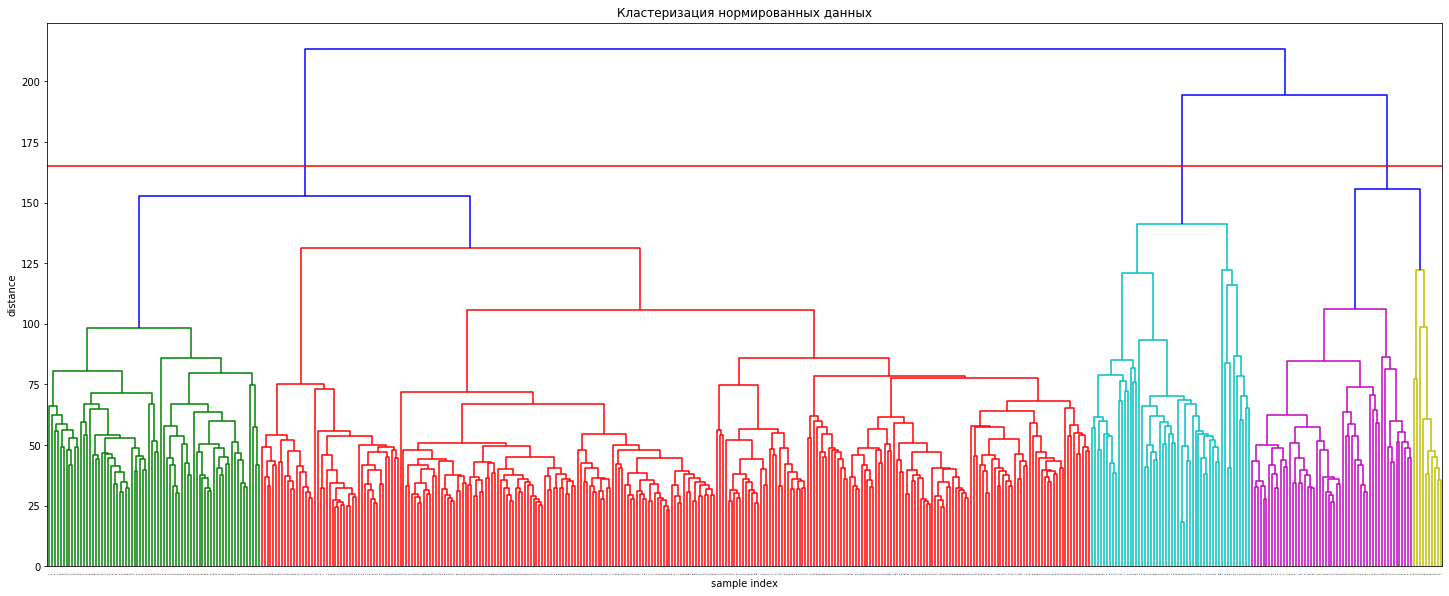

In [ ]:
plt.figure(figsize=(25, 10)) #строим двоичное дерево для нормированных данных
plt.title('Кластеризация нормированных данных')
plt.xlabel('sample index')
plt.ylabel('distance')
sci.dendrogram(
    Z1,
    leaf_rotation=9.,  
    leaf_font_size=2., 
)
plt.axhline(y=165, c='r')
plt.show()

In [ ]:
c, coph_dists = sci.cophenet(Z1, pdist(rna_seq_clast_arr1))
c

0.4791894104914065

Cophenetic correlation вышла конечно не очень, но что есть то есть. Продолжим кластеризацию

In [ ]:
rna_seq_clast1 = rna_seq_clast1.reset_index()
rna_seq_clast1.rename(columns = {"index" : "sample_ID"}, inplace= True) 

Выделим 3 самых больших кластера, полученных нами, и проанализируем экспрессию в каждом из них.

In [ ]:
rna_seq_clast1.rename_axis('index')
clasters = sci.fcluster(Z1, 3, criterion='maxclust') #выделяем 3 кластера и подписываем каждый образец
rna_seq_clast1.insert(1, "clasters", np.array(clasters))

In [ ]:
rna_seq_clast1 = rna_seq_clast1.rename_axis('', axis='columns')

Подготовим таблицы с пациентами и образцами для обратботки.

In [13]:
data_patient_proc = data_patient.set_index("Patient Identifier")
data_patient_proc = data_patient_proc.drop(["Clark level at diagnosis", "American Joint Committee on Cancer Publication Version Type", 'American Joint Committee on Cancer Tumor Stage Code', 'Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code', 
                                           'Neoplasm American Joint Committee on Cancer Clinical Distant Metastasis M Stage', "Neoplasm American Joint Committee on Cancer Clinical Regional Lymph Node N Stage", 'Neoplasm American Joint Committee on Cancer Clinical Primary Tumor T Stage', 
                                           'Neoplasm American Joint Committee on Cancer Clinical Group Stage', 'Project code', 'Disease code', 'Neoadjuvant Therapy Type Administered Prior To Resection Text', 'Neoplasm Disease Stage American Joint Committee on Cancer Code', 'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Histology Code',
                                           "Informed consent verified", "International Classification of Diseases for Oncology, Third Edition ICD-O-3 Site Code", 'ICD-10 Classification'], 1)
data_patient_proc = data_patient_proc.drop(['Identifier to uniquely specify a patient.', 'STRING', '1', 'PATIENT_ID'], 0)

In [14]:
data_sample_proc = data_sample.set_index("Sample Identifier")
data_sample_proc = data_sample_proc.drop(["Other Sample ID", 'Specimen Current Weight', 'Days to Sample Collection.', 'Days to Sample Procurement', 'Specimen Freezing Means', 'Sample Initial Weight', 
                       'Specimen Second Longest Dimension', 'Longest Dimension', "First Pathologic Diagnosis Biospecimen Acquisition Method Type", 
                       "Specimen Collection Method", 'Pathology Report File Name', 'Pathology report uuid', 'Shortest Dimension', "Time between clamping and freezing", 'Time between excision and freezing', 
                       'Oncotree Code'], 1)
data_sample_proc = data_sample_proc.drop(['A unique sample identifier.', 'STRING', '1', 'SAMPLE_ID'], 0)

Внесем кластеры в таблицу с образцами:

In [ ]:
data_sample_proc.insert(1, "claster", None)
rna_seq_clast1.set_index('sample_ID', inplace= True) 
for ind in rna_seq_clast1.index:
    data_sample_proc["claster"][ind] = rna_seq_clast1["clasters"][ind]

Проведем анализ выживаемости для каждого из кластеров:

In [ ]:
clast1_event = []
clast1_duration = []
clast2_event = []
clast2_duration = []
clast3_event = []
clast3_duration = []

for ind in data_sample_proc.index:
    if (data_sample_proc["claster"][ind] == 1) and (data_patient_proc['Overall Survival (Months)'][data_sample_proc['#Patient Identifier'][ind]] != "[Not Available]"):
        clast1_event.append(int(data_patient_proc['Overall Survival Status'][data_sample_proc['#Patient Identifier'][ind]][0]))
        clast1_duration.append(float(data_patient_proc['Overall Survival (Months)'][data_sample_proc['#Patient Identifier'][ind]]))
    if (data_sample_proc["claster"][ind] == 2) and (data_patient_proc['Overall Survival (Months)'][data_sample_proc['#Patient Identifier'][ind]] != "[Not Available]"):
        clast2_event.append(int(data_patient_proc['Overall Survival Status'][data_sample_proc['#Patient Identifier'][ind]][0]))
        clast2_duration.append(float(data_patient_proc['Overall Survival (Months)'][data_sample_proc['#Patient Identifier'][ind]]))
    if (data_sample_proc["claster"][ind] == 3) and (data_patient_proc['Overall Survival (Months)'][data_sample_proc['#Patient Identifier'][ind]] != "[Not Available]"):
        clast3_event.append(int(data_patient_proc['Overall Survival Status'][data_sample_proc['#Patient Identifier'][ind]][0]))
        clast3_duration.append(float(data_patient_proc['Overall Survival (Months)'][data_sample_proc['#Patient Identifier'][ind]]))

Text(0, 0.5, 'Выживаемость')

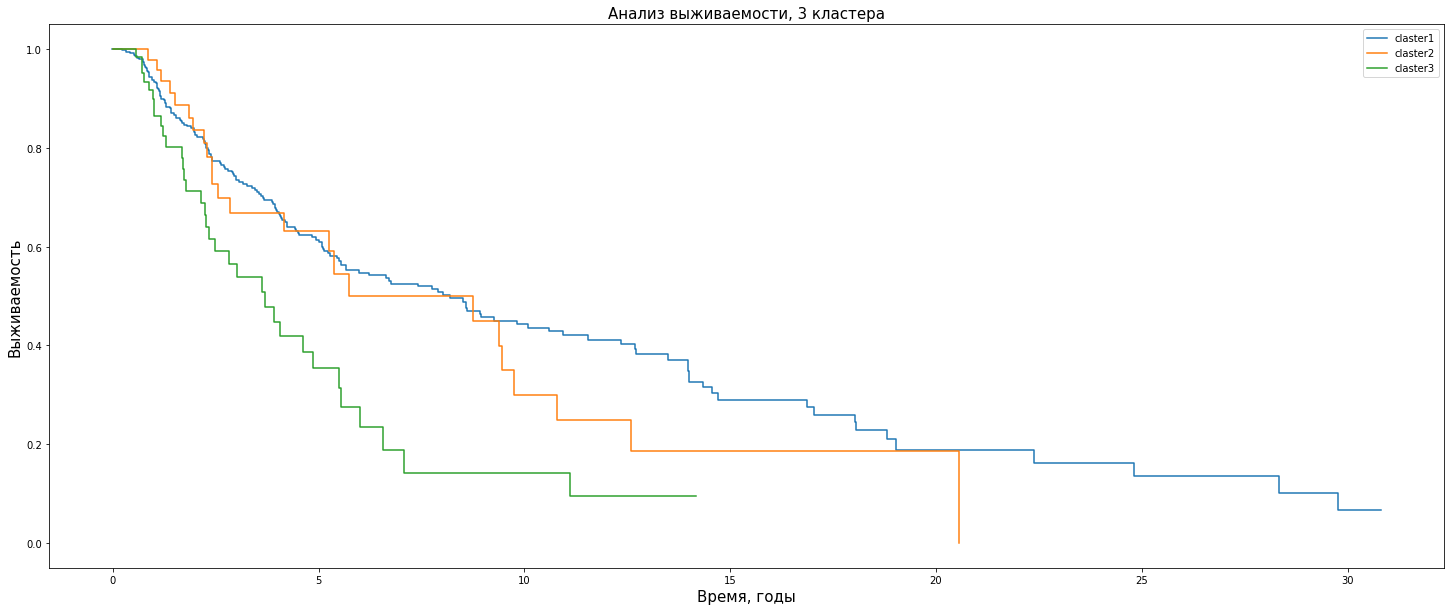

In [ ]:
plt.figure(figsize=(25, 10))
kmf1 = KaplanMeierFitter() 
kmf1.fit(np.array(clast1_duration)/12, clast1_event ,label='claster1')
kmf1.plot(ci_show=False)
kmf2 = KaplanMeierFitter() 
kmf2.fit(np.array(clast2_duration)/12, clast2_event ,label='claster2')
kmf2.plot(ci_show=False)
kmf3 = KaplanMeierFitter() 
kmf3.fit(np.array(clast3_duration)/12, clast3_event ,label='claster3')
kmf3.plot(ci_show=False)
plt.title('Анализ выживаемости, 3 кластера', size = 15)
plt.xlabel('Время, годы', size = 15)
plt.ylabel('Выживаемость', size = 15)

In [ ]:
rna_seq_clast1 = rna_seq_clast1.drop(['UBE2Q2P3'], 1) #в таблице 2 гена с этим именем, что мешает обработке

Из supplementary data второй статьи выберем гены, по которым была произведена классификация и которые идентифицируемы в нашем датасете. 

In [ ]:
table_art_2 = pd.read_csv("GENEs.txt", sep = " ")
genes = list(table_art_2['SYMBOL'])
set_genes = set(genes)
known_genes_set = set(rna_seq.index)
genes_proc = set_genes.intersection(known_genes_set)
len(genes_proc) #выведем, сколько генов удалось идентифицировать (всего их порядка 350)

250

Из-за по-разному названных генов в разных таблицах у нас пропало порядка 100 генов, которые мы попытаемся восстановить используя Entrez_Gene_Id и Gene Symbol

In [ ]:
mg = mygene.MyGeneInfo()
genes_ID = []
for gene in set_genes.difference(known_genes_set):
    if mg.query(gene, fields='entrezgene')['hits']:
        try:
            genes_ID.append(mg.query(gene, fields='entrezgene')['hits'][0]['entrezgene'])
        except (KeyError):
            pass

for id in genes_ID:
    if rna_seq[rna_seq["Entrez_Gene_Id"] == int(id)].index.tolist():
        genes_proc.add(rna_seq[rna_seq["Entrez_Gene_Id"] == int(id)].index.tolist()[0])
len(genes_proc) #опять выведем число генов, но уже после автоматического их поиска в интернете

314

Как видим, большую часть генов удалось восстановить. Теперь проведем кластеризацию по ним и выделим 4 кластера.

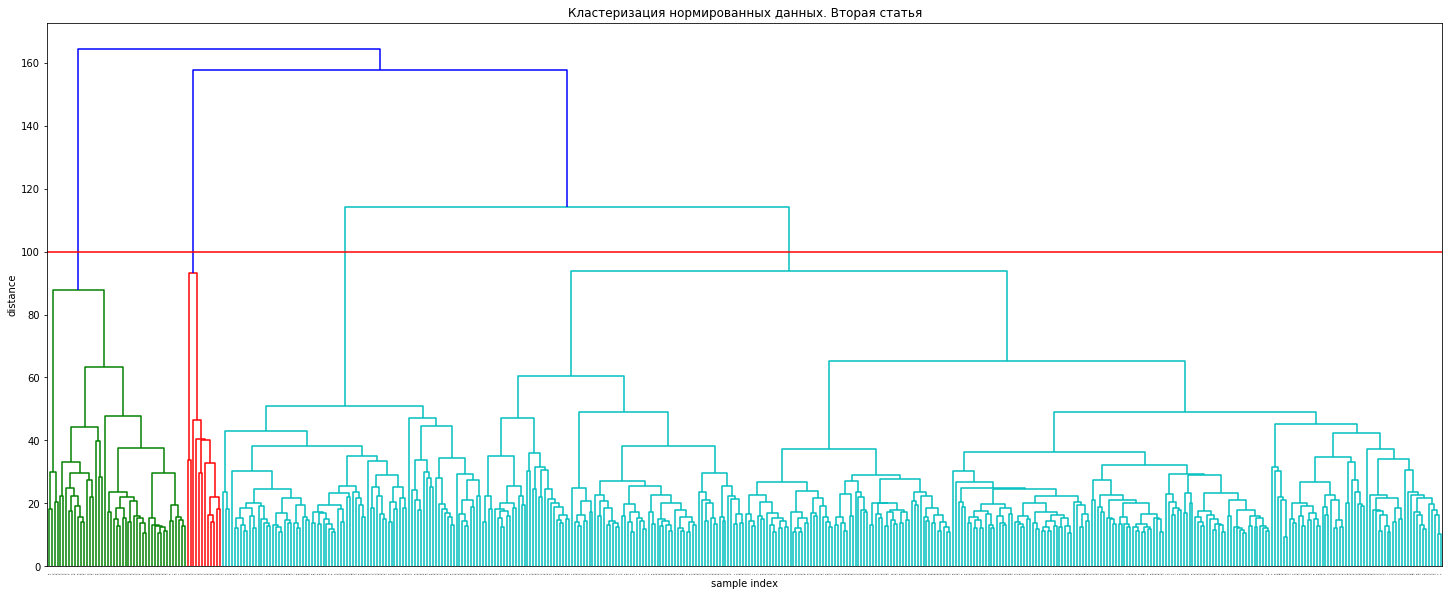

In [ ]:
rna_seq_clast_new = rna_seq.loc[genes_proc].copy()
rna_seq_clast_new = rna_seq_clast_new.drop("Entrez_Gene_Id", 1)
rna_seq_clast_new = rna_seq_clast_new.drop("mad", 1)
rna_seq_clast_new = (rna_seq_clast_new.T - rna_seq_clast_new.T.mean())/rna_seq_clast_new.T.std()
rna_seq_clast_new = rna_seq_clast_new.dropna(1)
rna_seq_clast_new_arr = np.array(rna_seq_clast_new)
Z_new = sci.linkage(rna_seq_clast_new_arr, 'ward')

plt.figure(figsize=(25, 10))
plt.title('Кластеризация нормированных данных. Вторая статья')
plt.xlabel('sample index')
plt.ylabel('distance')
sci.dendrogram(
    Z_new,
    leaf_rotation=9.,  
    leaf_font_size=2., 
)
plt.axhline(y=100, c='r')
plt.show()

Проанализируем выживаемость в каждом из 4х кластеров.

In [ ]:
clasters_new = sci.fcluster(Z_new, 100, criterion='distance') 
data_sample_proc.insert(1, "claster_new", None)
rna_seq_clast1.insert(1, "clasters_new", np.array(clasters_new))
rna_seq_clast_new.insert(1, "clasters_new", np.array(clasters_new))
for ind in rna_seq_clast1.index:
    data_sample_proc["claster_new"][ind] = rna_seq_clast1["clasters_new"][ind]

clast1_event = []
clast1_duration = []
clast2_event = []
clast2_duration = []
clast3_event = []
clast3_duration = []
clast4_event = []
clast4_duration = []

for ind in data_sample_proc.index:
    if (data_sample_proc["claster_new"][ind] == 1) and (data_patient_proc['Overall Survival (Months)'][data_sample_proc['#Patient Identifier'][ind]] != "[Not Available]"):
        clast1_event.append(int(data_patient_proc['Overall Survival Status'][data_sample_proc['#Patient Identifier'][ind]][0]))
        clast1_duration.append(float(data_patient_proc['Overall Survival (Months)'][data_sample_proc['#Patient Identifier'][ind]]))
    if (data_sample_proc["claster_new"][ind] == 2) and (data_patient_proc['Overall Survival (Months)'][data_sample_proc['#Patient Identifier'][ind]] != "[Not Available]"):
        clast2_event.append(int(data_patient_proc['Overall Survival Status'][data_sample_proc['#Patient Identifier'][ind]][0]))
        clast2_duration.append(float(data_patient_proc['Overall Survival (Months)'][data_sample_proc['#Patient Identifier'][ind]]))
    if (data_sample_proc["claster_new"][ind] == 3) and (data_patient_proc['Overall Survival (Months)'][data_sample_proc['#Patient Identifier'][ind]] != "[Not Available]"):
        clast3_event.append(int(data_patient_proc['Overall Survival Status'][data_sample_proc['#Patient Identifier'][ind]][0]))
        clast3_duration.append(float(data_patient_proc['Overall Survival (Months)'][data_sample_proc['#Patient Identifier'][ind]]))
    if (data_sample_proc["claster_new"][ind] == 4) and (data_patient_proc['Overall Survival (Months)'][data_sample_proc['#Patient Identifier'][ind]] != "[Not Available]"):
        clast4_event.append(int(data_patient_proc['Overall Survival Status'][data_sample_proc['#Patient Identifier'][ind]][0]))
        clast4_duration.append(float(data_patient_proc['Overall Survival (Months)'][data_sample_proc['#Patient Identifier'][ind]]))

Text(0, 0.5, 'Выживаемость')

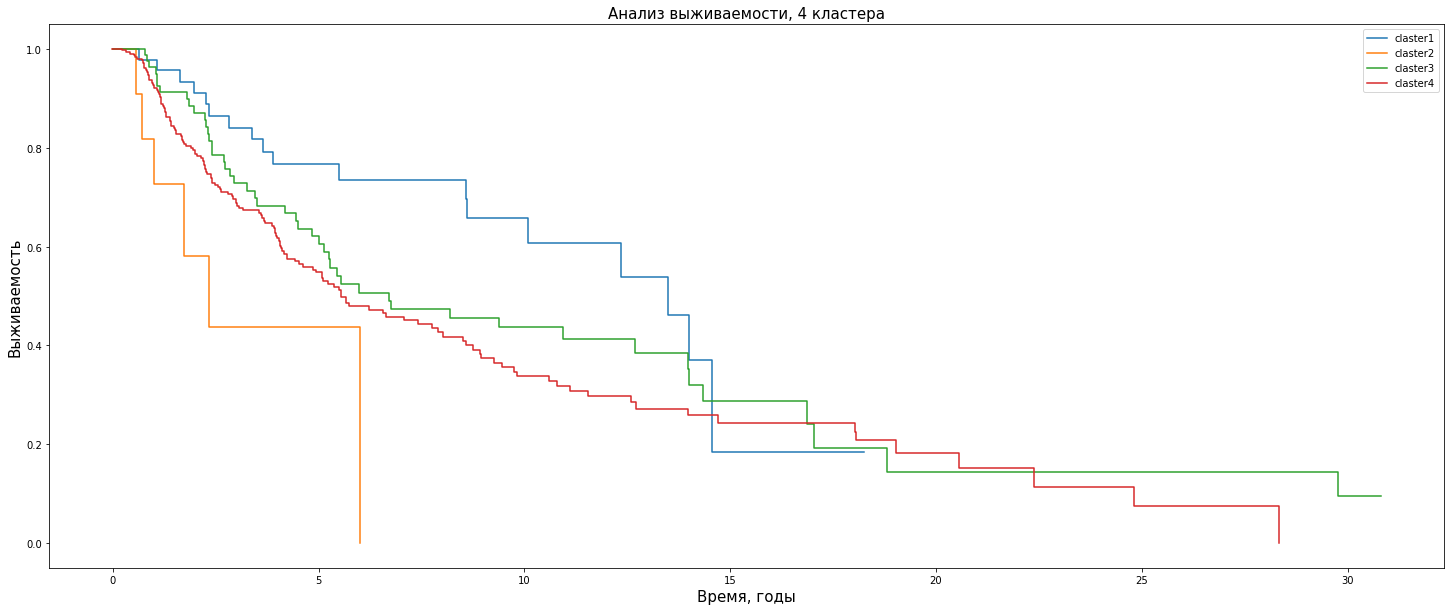

In [ ]:
plt.figure(figsize=(25, 10))
kmf1 = KaplanMeierFitter() 
kmf1.fit(np.array(clast1_duration)/12, clast1_event ,label='claster1')
kmf1.plot(ci_show=False)
kmf2 = KaplanMeierFitter() 
kmf2.fit(np.array(clast2_duration)/12, clast2_event ,label='claster2')
kmf2.plot(ci_show=False)
kmf3 = KaplanMeierFitter() 
kmf3.fit(np.array(clast3_duration)/12, clast3_event ,label='claster3')
kmf3.plot(ci_show=False)
kmf4 = KaplanMeierFitter() 
kmf4.fit(np.array(clast4_duration)/12, clast4_event ,label='claster4')
kmf4.plot(ci_show=False)
plt.title('Анализ выживаемости, 4 кластера', size = 15)
plt.xlabel('Время, годы', size = 15)
plt.ylabel('Выживаемость', size = 15)

Приступим к более детальному анализу экспресии, построив heatmap-ы для наиболее альтернативно-экспрессированных генов в каждом из образцов. Порядок кластеров - 1, 2, 3.  
Для удобства работы зададим функции, возвращающие датасеты для анализа, а так же функции, выявляющие up и down экспрессированные гены, сравнивая среднее их экспрессии по кластеру с средним по экспрессии по всем образцам.

In [ ]:
rna_seq_clast_new = rna_seq_clast_new.drop(['DLX6'], 1)
def claster_data_prep(claster_number, cl_t = 0): #claster_number - номер кластера, cl_t = 0 - статья с 3мя кластерами, cl_t = 1 - статья с 4мя кластерами
    if cl_t == 0:
        claster_data = rna_seq_clast1[rna_seq_clast1["clasters"] == claster_number].copy()
    elif cl_t == 1:
        claster_data = rna_seq_clast_new[rna_seq_clast_new["clasters_new"] == claster_number].copy()
    return claster_data

In [ ]:
def overexpression(claster_data, rate = 0.1): # claster_data - DataFrame с кластеризованными данными, rate - степень отличия от средней экспрессии по всем образцам
    overexpressed_genes = []
    for i in claster_data.columns:
        if claster_data[i].mean() > rna_seq_clast1[i].mean() + rate:
            overexpressed_genes.append(i)
    return (overexpressed_genes)

def downexpression(claster_data, rate = 0.1):
    downexpressed_genes = []
    for i in claster_data.columns:
        if claster_data[i].mean() < rna_seq_clast1[i].mean() - rate:
            downexpressed_genes.append(i)
    return (downexpressed_genes)

def downexpression_new(claster_data, rate = 0.1):
    downexpressed_genes = []
    for i in claster_data.columns:
        if claster_data[i].mean() < rna_seq_clast_new[i].mean() - rate:
            downexpressed_genes.append(i)
    return (downexpressed_genes)

def overexpression_new(claster_data, rate = 0.1):
    uppexpressed_genes = []
    for i in claster_data.columns:
        if claster_data[i].mean() > rna_seq_clast_new[i].mean() + rate:
            uppexpressed_genes.append(i)
    return (uppexpressed_genes)



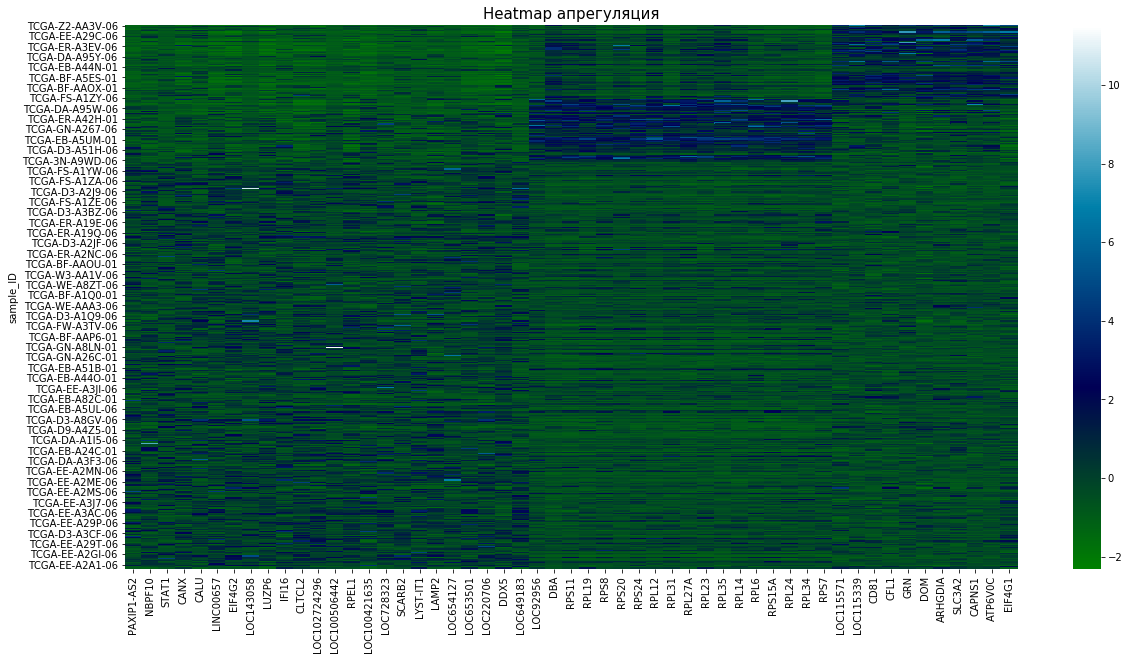

In [ ]:
plt.figure(figsize=(20, 10)) #построим heatmap для наиболее апрегуированных генов в каждом из кластеров. 
plt.title('Heatmap апрегуляция', size = 15)
ax = sns.heatmap(rna_seq_clast1.sort_values(["clasters"], ascending=False)[overexpression(claster_data_prep(1), 0.17) + overexpression(claster_data_prep(2), 1.5) + overexpression(claster_data_prep(3), 1.3)[1:]],
                cmap="ocean")

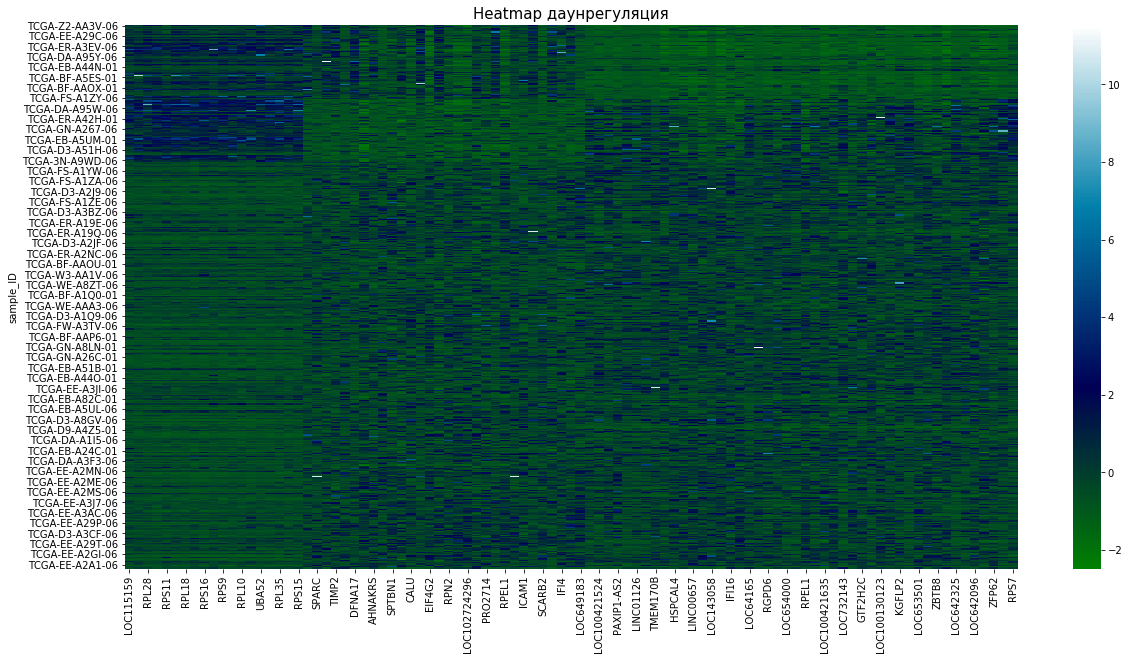

In [ ]:
plt.figure(figsize=(20, 10))
plt.title('Heatmap даунрегуляция', size = 15)
ax = sns.heatmap(rna_seq_clast1.sort_values(["clasters"], ascending=False)[downexpression(claster_data_prep(1), 0.3)[1:] + downexpression(claster_data_prep(2), 0.5)[1:] + downexpression(claster_data_prep(3), 0.7)],
                cmap="ocean")

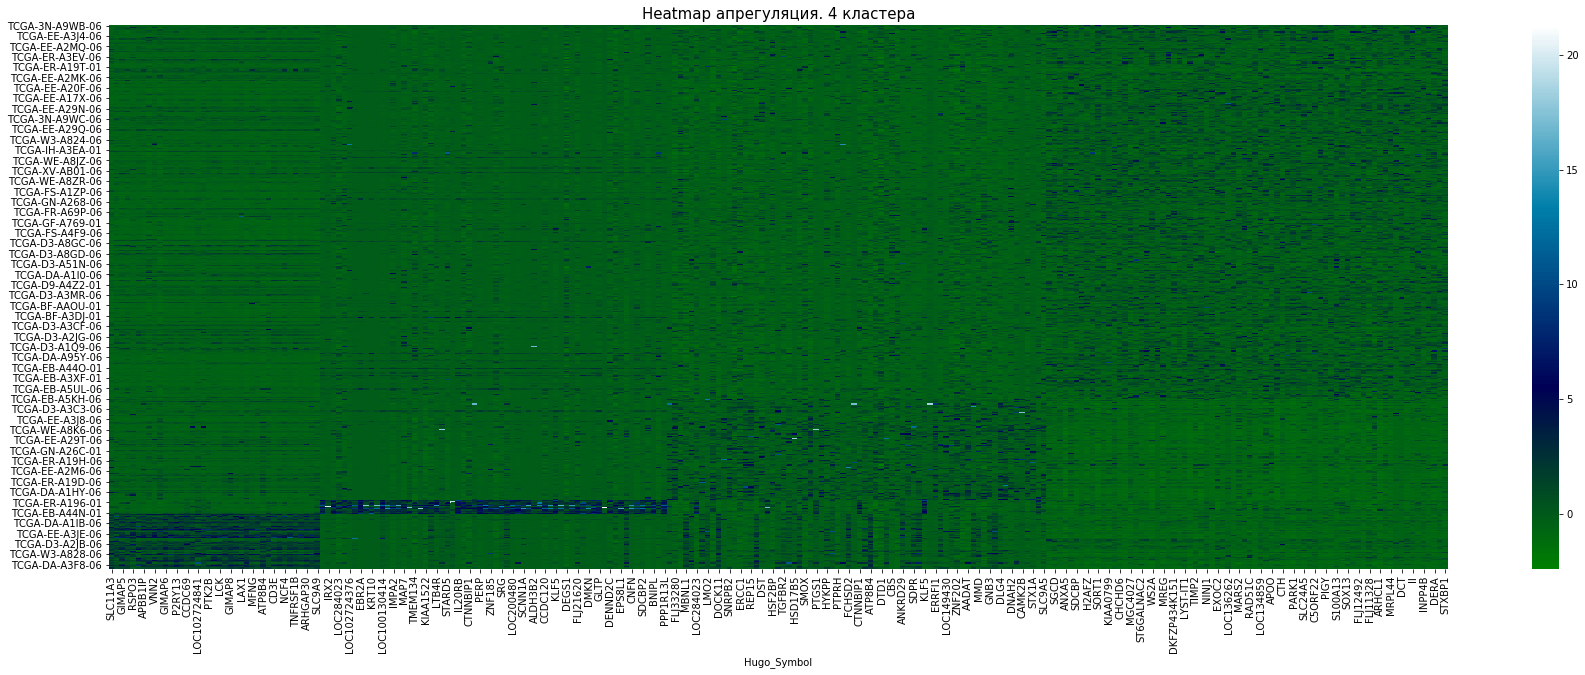

In [ ]:
plt.figure(figsize=(30, 10))
plt.title('Heatmap апрегуляция. 4 кластера', size = 15)
ax = sns.heatmap(rna_seq_clast_new.sort_values(["clasters_new"], ascending=False)[overexpression_new(claster_data_prep(1, 1), 1.7) + overexpression_new(claster_data_prep(2, 1), 1) + overexpression_new(claster_data_prep(3, 1), 0.1) + overexpression_new(claster_data_prep(4, 1), 0.1)[1:]],
                cmap="ocean")

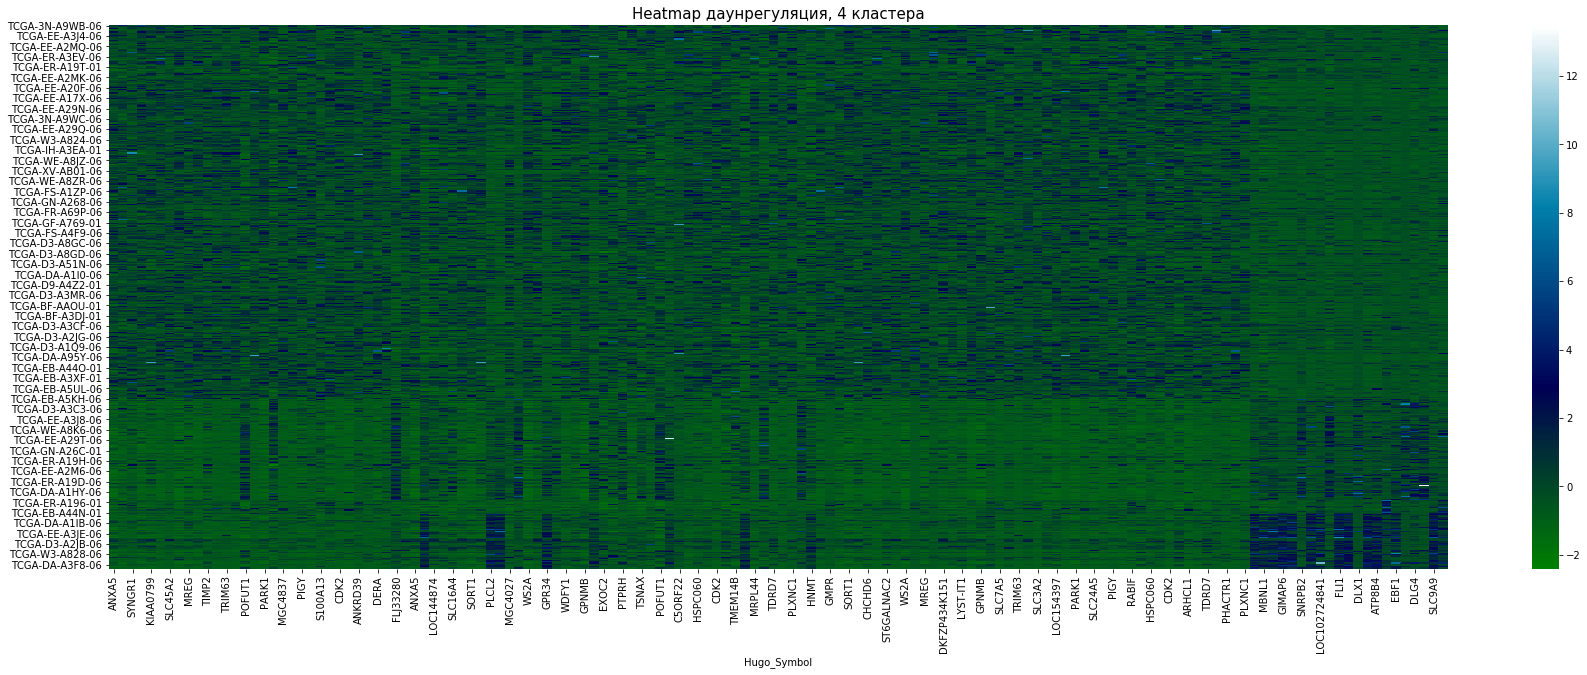

In [ ]:
plt.figure(figsize=(30, 10))
plt.title('Heatmap даунрегуляция, 4 кластера', size = 15)
ax = sns.heatmap(rna_seq_clast_new.sort_values(["clasters_new"], ascending=False)[downexpression_new(claster_data_prep(1, 1), 0.5)[1:] + downexpression_new(claster_data_prep(2, 1), 0.5)[1:] + downexpression_new(claster_data_prep(3, 1), 0.5)[1:] + downexpression_new(claster_data_prep(4, 1), 0.25)],
                cmap="ocean")

На каждой из 4х диаграм можно в той или иной степени отследить кластеризуемость данных. Обратим внимание на состав кластеров с выраженной большей выживаемостью:

In [ ]:
cl1 = overexpression(claster_data_prep(1), 0.15)

1 кластер:  
Множество менее оверэкспресиированных белков, ассоциированных с иммунным ответом на опухоли. 
Множество белков, реагирующих на DNA damge и в целом на клеточный стресс, что можно ассоциировать с хорошим прогнозом, что полностью соотноситься с Kaplan Meier Diagram.  
Этот подклас соотносится с подклассом "immune" первой статьи.

In [ ]:
genes_MTIFF_LOW_prop = set(downexpression(claster_data_prep(2), 0.2))
genes_MTIFF_LOW = str("1, DCT, KIT, SILV(gp100), TRPM1, CDKN2A, GZMB, GAPDHS, CA14, HPGD, KCNN2, MCOLN3, PLA1A, BCAN, SLC16A6, ABCC2, FXYD3, SCUBE2, , LDB3, PSCA")
genes_MTIFF_LOW = set(genes_MTIFF_LOW.split(', '))
intersect = genes_MTIFF_LOW.intersection(genes_MTIFF_LOW_prop)

2 кластер:  
Скорее всего это "MITF-low" подтип.  
Действительно наблюдается пересечение с даунрегуляцией перечилсенных в supplementary data статьи белков, что и послужило критерием выделения данного подтипа. Анализ выживаемости также корелирует со статьей. Стоит также отметить крайне высокую степень экспресии рибосомальных белков, что может быть ассоциировано с немного меньшей выживаемостью этого подкласса.

In [ ]:
genes_keratin_prop = set(overexpression(claster_data_prep(3), 1)) #списки генов анализировались в ручную при помощи genecards

3 кластер:  
Среди оверэкспрессированных генов в третьем кластере действительно наблюдаются гены, ответственные за пигментацию, а также и гены, ответсвенные за развитие нервной системы, причем некоторые из них не были выделены авторами в таблице в Supplememenatary Data, что ещё раз подтверждает их гипотезу. Таким образом мы можем идентифицировать этот кластер как "Keratin" подкласс. Так же стоит отметить наличие генов, ассоциированых с регуляцией апоптоза. Альтернативная экспрессия многих генов из выборки, согласно genecards, ассоциирована с онкологическими заболеваниями, что корелилрует с гораздо меньшей выживаемостью пациентов, так как в их образцах она выражена весьма сильно.

Вывод:  
Нам удалось повторить класстеризацию из первой статьи, но резульаты можно назвать скорее схожими, чем идетнтичными.  
Рассмотрим вторую статью.

In [ ]:
genes_immune_prop_new = set(overexpression_new(claster_data_prep(1, 1), 2))

1 кластер:  
Большинство генов, оверэкспрессированных в пробах действительно ассоциированы с имунитетом, что дает нам полное право предположить, что этот кластер аналогичен high-immune response подтипу во второй статье. Это подтверждается анализом survival plot - пациенты с таким патерном экспрессии демонстрируют куда боьшую выживаемость.

In [ ]:
genes_normal_prop_new = set(overexpression_new(claster_data_prep(2, 1), 2))

2 кластер:  
Судя по большой экспрессии кератинов, его стоит отнести к normal type подклассу, но в отличии от второй статьи, мы получли, что выживаемость в этом подклассе очень низкая. Но это соотносится с тем фактом, что кластер с повышенной экспрессией кератинов, выделенный в первой статье, отличался высокой смертностью пациентов. Возможно суть различий кроется в выборке пациентов. 

In [ ]:
genes_pigmentation_prop_new = set(overexpression_new(claster_data_prep(4, 1), 0.2))
genes_pigmentation_prop_new_down = set(downexpression_new(claster_data_prep(4, 1), 0.2))

Кластеры 3 и 4  
Эти 2 кластера, как видно из дендограммы, лежат достаточно близко. Достаточно трудно выделить из списка up и down регулированных генов те, по которым их можно было бы отнести к тому или иному подтипу, но с некоторой долей уверенности можно сказать, что из-за даунэкспрессии генов, ассоциированных с имунитетом, кластер 4 можно связать с субтипом 'proliferative'. По краней мере, если задаваться целью сопоставить их с подклассами, описанными в статье. Подтверждением этой гипотезы может служить также тот факт, что 4 кластер демонстрирует одну из самых ннизких выживаемостей. Но в целом можно сказать, что эти 2 кластера определяются плохо. 

Выводы:  
Можно уверенно выделить 2 из 4х подтипов, описанных в статье, но это объясняется утерей некоторых генов, на основе которых мы должны были выделять кластеры и другим датасетом для кластеризации.

Общие выводы:  
Один из подтипов в обоих статьях, связанный с апрегуляцией маркеров иммунитета, хорошо выделяется двумя способами и ассоциирован с бОльшей выживаемостью пациентов.  
Примечательно, что подкласс, ассоциированный с сильной экспрессией кератинов в одном исследовании демострировал плохую выживаемость, а в другом одну из наилучших. Возможно причина этого в разных датасетах, на которых проводилась кластеризация. Но так как мы брали датасет первого исследования, этот подкласс демонстрирует низкую выживаемость.  
Последний подкласс из третьего исследования так же идентифицируется в большей, чем в оригинальном исследовании, выборке, что говорит об успешности нашей кластеризации.  
Немного сложнее дело обстоит с 2 (pigmentation и proliferative) подклассами второй статьи. Но это можно объяснить тем, что нам не удалось идентифицировать все гены для кластеризации (около 40 из 300 было утеряно).  
Отоношение количества образцов в каждом из подтипов, выявленных при помощи кластеризации, описанной в первой статье, так же качественно соотносится с оригинальным распределением образцов по подтипам.  
В целом выделенные нами кластеры распознаются на heatmap-aх и демонстрируют различия в выживаемости. Гены, диф. экспрессированные в каждом из них действительно отражают их биологические особенности и соотносятся с survival plot.